In [1]:
def cosine(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)+1e-12)

# The "0.866" Mystery

I observed a final similarity of 0.8716. This isn't random. There is a mathematical reason for this specific number.

If you take a random vector $X$ where components are $Unif(−1,1)$ and "retrieve" its bipolar version (its sign), the expected cosine similarity is exactly  $\frac{\sqrt{3}}{2}≈0.866$.

$$Similarity= \frac{E[|X|]}{\sqrt{E[X^2]} \cdot \sqrt{E[sgn(X)^2]}} = \frac{0.5}{\sqrt{1/3}\cdot 1} = \frac{\sqrt{3}}{2}$$
The model is essentially taking the soft uniform pattern and sharpening it into a binary vector. The energy decreases because the magnitude of the projections increases significantly when the state moves to the corners of the hypercube.
## Point sampling
Let's consider the case for 2D. Using `np.random.uniform(-1, 1)`, we are effectively picking a point anywhere inside that square. On average, most of them are going to be in the middle. The update rule uses the `tanh` function. It wants to squash every neuron towards the boundaries `1.0` or `-1.0`. The energy function $E = -\sum F(projection)$ is minimzed when the projection (dot product between the state and the pattern) is as large as possible.
Because the patterns have many values near 0, the model realizes it can get a much larger projection (and thus lower energy) by moving the state from the "soft" interior point to the "hard" corner of the hypercube.
## Possible workarounds
Regularizations!!!! your vectors diverging away? pull them back by regularization! The new energy function will have the following expression:
$$E_{new}=E_{DAM} + \frac{\lambda}{2}||\vec{s}||^2$$
Something that i need to investigate is the range of lambdas that are suitable for each power of n

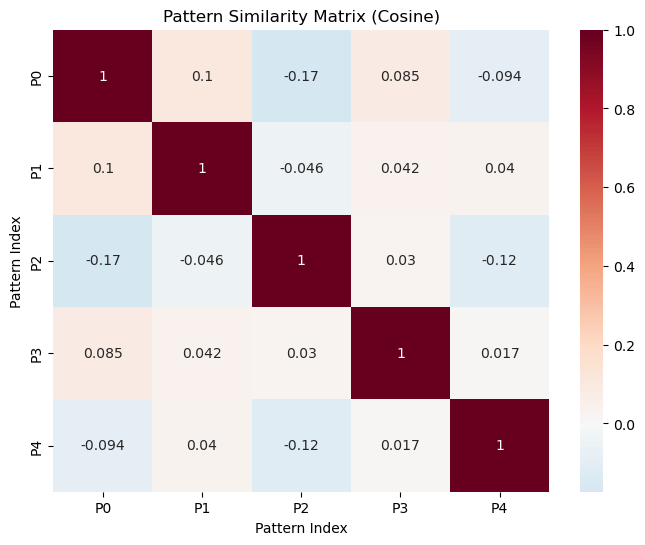

mem_term:  -1684652.549947008
reg_term:  18051.19830920221
mem_term:  -1835956.136272928
reg_term:  19155.175807967906
mem_term:  -1997501.9615333872
reg_term:  20206.76703531875
mem_term:  -2127257.3231035643
reg_term:  21158.52757960023
mem_term:  -2282308.640193111
reg_term:  22258.21843415718
mem_term:  -2471469.3795701903
reg_term:  23195.003985309882
mem_term:  -2637993.158051439
reg_term:  24276.838924138134
mem_term:  -2793624.36364325
reg_term:  25310.929845072656
mem_term:  -3006891.405200579
reg_term:  26467.884041371224
mem_term:  -3124079.136747533
reg_term:  27277.820180966264
mem_term:  -3219418.140962093
reg_term:  28278.167368566425
mem_term:  -3348834.1614135215
reg_term:  29188.03259436188
mem_term:  -3449429.495771303
reg_term:  29725.887476791366
mem_term:  -3605429.6221842472
reg_term:  30625.40572065495
mem_term:  -3704259.414957028
reg_term:  31106.52229553032
mem_term:  -3891073.099780723
reg_term:  32037.748587404854
mem_term:  -4021457.356019934
reg_term:  32

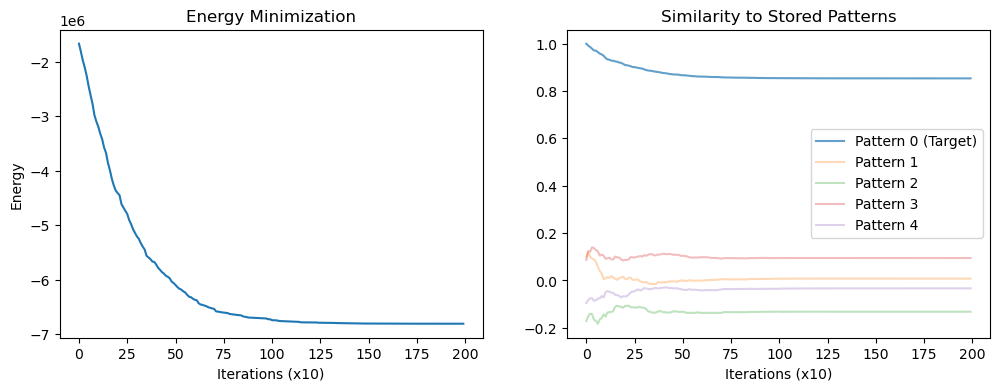

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from DAM import DenseAssociativeMemory
import seaborn as sns

def plot_pattern_correlations(patterns):
    """
    Computes and plots the cosine similarity between all pairs of stored patterns.
    """
    K = patterns.shape[0]
    similarity_matrix = np.zeros((K, K))
    
    for i in range(K):
        for j in range(K):
            similarity_matrix[i, j] = cosine(patterns[i], patterns[j])
            
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, annot=True, cmap='RdBu_r', center=0,
                xticklabels=[f"P{i}" for i in range(K)],
                yticklabels=[f"P{i}" for i in range(K)])
    plt.title("Pattern Similarity Matrix (Cosine)")
    plt.xlabel("Pattern Index")
    plt.ylabel("Pattern Index")
    plt.show()


def test_dam_retrieval():
    N = 100   
    K = 5     
    n = 4     
    beta = 0.01    
    alpha = 0.5  
    noise_lvl = 0
    
    # Generate Random Patterns in (-1, 1)
    # We use sign then scale slightly to keep them near the boundaries but continuous
    patterns = np.random.uniform(-1, 1, (K, N))
    # plot the correlations between the patterns
    plot_pattern_correlations(patterns)
    # initialize Model
    dam = DenseAssociativeMemory(patterns, n=n, beta=beta, alpha=alpha, lmbda=1000)
    
    # create a noisy query
    target_idx = 0
    target_pattern = patterns[target_idx]
    noisy_query = target_pattern + np.random.normal(0, noise_lvl, N)
    noisy_query = np.clip(noisy_query, -1, 1) # keep within bounds
    
    # we run N * 20 steps to ensure every neuron is updated many times
    retrieved_state, best_match, energy_trace, sim_trace = dam.retrieve_differential(
        noisy_query, steps=N * 20
    )
    
    # evaluation
    initial_sim = cosine(target_pattern, noisy_query)
    final_sim = cosine(target_pattern, retrieved_state)
    
    print(f"--- Retrieval Test (Pattern {target_idx}) ---")
    print(f"Initial Cosine Similarity: {initial_sim:.4f}")
    print(f"Final Cosine Similarity:   {final_sim:.4f}")

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    ax[0].plot(energy_trace)
    ax[0].set_title("Energy Minimization")
    ax[0].set_xlabel("Iterations (x10)")
    ax[0].set_ylabel("Energy")
    
    # Plot similarity to all patterns over time
    sim_trace_array = np.array(sim_trace)
    for k in range(K):
        label = f"Pattern {k}" + (" (Target)" if k == target_idx else "")
        ax[1].plot(sim_trace_array[:, k], label=label, alpha=0.7 if k == target_idx else 0.3)
    
    ax[1].set_title("Similarity to Stored Patterns")
    ax[1].set_xlabel("Iterations (x10)")
    ax[1].legend()
    plt.show()

# Run the test
test_dam_retrieval()

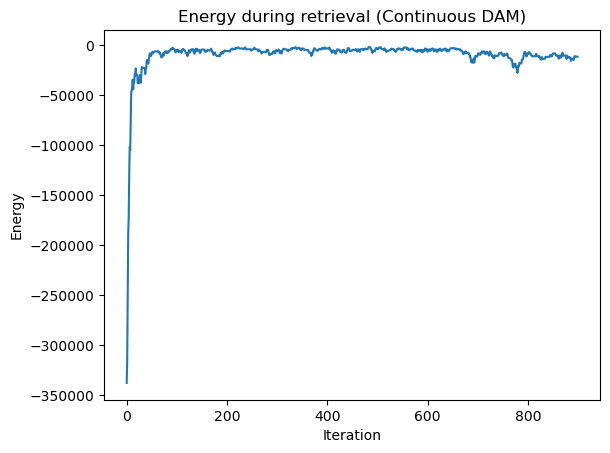

Cosine with true pattern: 0.24398380897466207
Cosine with all patterns:  [0.24398380897466207, 0.5918422068745726, -0.18988351616618385, -0.027014937719656813, 0.06901578711038658, 0.5881628841372891, 0.14675879071444048, 0.048795851617151303, -0.01771689324209665, 0.27219678230078387, -0.2994882687438729, -0.03348544358048781, 0.18332431271192887, -0.45085438486056006, -0.021651656736320413]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from DAM import DenseAssociativeMemory

# simple random patterns for testing
K = 15
N = 20
"""
Track changes for different values for the relaxation paramaters

"""
patterns = np.random.choice([-1,1], size=(K,N))

dam = DenseAssociativeMemory(patterns, n=4, beta=2.0, alpha=0.5)

# pick one pattern and add gaussian noise
target = patterns[0].copy()
noisy = target + 0.5*np.random.randn(N)

retrieved, best, energy_trace, simi_trace = dam.retrieve(noisy, steps=900)

plt.plot(energy_trace)
plt.title("Energy during retrieval (Continuous DAM)")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()

print("Cosine with true pattern:", cosine(retrieved, target))
cosine_with_all = [cosine(retrieved, pattern) for pattern in patterns]
print("Cosine with all patterns: ", cosine_with_all)


In [111]:
import numpy as np
import matplotlib.pyplot as plt
from DAM import DenseAssociativeMemory
N = 5         
ks = [1, 5, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 300, 400, 500, 600, 700, 800, 900]        
steps = 500       
noise_std = 0.8   
tolerance = 0.1   

K_values = []
recall_counts = []

for K in ks:
    patterns = np.random.choice([-1,1], size=(K,N))
    
    dam = DenseAssociativeMemory(patterns, n=2, beta=2, alpha=0.1)
    
    average_recall_simi = 0
    correct_recalls = 0
    for i in range(K):
        target = patterns[i].copy()
        noisy = target + noise_std*np.random.randn(N)
        retrieved, best, energy_trace, simi_trace = dam.retrieve_differential(noisy, steps=steps)

        if (1 - cosine(retrieved, target)) <= tolerance:
            correct_recalls += 1
        average_recall_simi += cosine(retrieved, target)

    average_recall_simi /= K
    K_values.append(K)
    recall_counts.append(correct_recalls / K)
    print(f"K={K}, correctly recalled: {correct_recalls/K * 100}% with average recall accuracy of {average_recall_simi}")

plt.figure(figsize=(8,5))
plt.plot(K_values, recall_counts, marker='o')
plt.xlabel("Number of stored patterns K")
plt.ylabel("Number of correctly recalled patterns")
plt.title("DAM Recall Performance vs Number of Patterns")
plt.grid(True)
plt.show()


K=2, Success Rate: 100.0%
K=10, Success Rate: 70.0%
K=50, Success Rate: 56.0%
K=100, Success Rate: 56.0%
K=200, Success Rate: 54.0%
K=400, Success Rate: 60.0%


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Fix: Use Binary Patterns for Clear Retrieval ---
N = 100         
ks = [2, 10, 50, 100, 200, 400, 600] 
steps = 1000       # N=100 needs time to settle
noise_std = 0.2    # Standard noise
tolerance = 0.9    # We'll check for similarity >= 0.9

def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-12)

results = []

for K in ks:
    # Use Binary Patterns (-1, 1)
    patterns = np.random.choice([-1.0, 1.0], size=(K, N))
    
    # beta=1.0 is usually enough when patterns are not normalized to 1.0
    dam = DenseAssociativeMemory(patterns, n=4, beta=1.0, alpha=0.3)
    
    correct_recalls = 0
    # We only test a subset of K for speed if K is huge
    test_limit = min(K, 50) 
    
    for i in range(test_limit):
        target = patterns[i].copy()
        noisy = target + noise_std * np.random.randn(N)
        
        retrieved, _, _, _ = dam.retrieve_differential(noisy, steps=steps)

        # Check success
        if cosine(retrieved, target) >= tolerance:
            correct_recalls += 1

    success_rate = correct_recalls / test_limit
    results.append(success_rate)
    print(f"K={K}, Success Rate: {success_rate*100:.1f}%")

plt.figure(figsize=(8, 5))
plt.plot(ks, results, 'o-', color='blue', linewidth=2)
plt.axhline(y=0.9, color='r', linestyle='--', label="High Reliability Zone")
plt.xlabel("Number of Patterns (K)")
plt.ylabel("Success Rate")
plt.title(f"DAM Capacity: The 'Cliff' (N={N}, n=4)")
plt.grid(True)
plt.legend()
plt.show()

In [5]:
N = 100         
max_K = 50        
steps = 500       
noise_std = 0.5   
tolerance = 0.1   

K_values = []
recall_counts = []

for K in range(1, max_K + 1):
    patterns = np.random.choice([-1,1], size=(K,N))
    dam = DenseAssociativeMemory(patterns, n=4, beta=2, alpha=1)
    
    average_recall_simi = 0
    correct_recalls = 0
    for i in range(K):
        target = patterns[i].copy()
        noisy = target + noise_std*np.random.randn(N)
        retrieved, best, trace = dam.retrieve(noisy, steps=steps)

        if (1 - cosine(best, target)) <= tolerance:
            correct_recalls += 1
        average_recall_simi += cosine(retrieved, target)

    average_recall_simi /= K
    K_values.append(K)
    recall_counts.append(correct_recalls)
    print(f"K={K}, correctly recalled: {correct_recalls}/{K} with average recall accuracy of {average_recall_simi}")

plt.figure(figsize=(8,5))
plt.plot(K_values, recall_counts, marker='o')
plt.xlabel("Number of stored patterns K")
plt.ylabel("Number of correctly recalled patterns")
plt.title("DAM Recall Performance vs Number of Patterns")
plt.grid(True)
plt.show()


ValueError: too many values to unpack (expected 3)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from DAM import DenseAssociativeMemory
N = 20        
max_K = 50        
steps = 500       
noise_std = 0.5   
tolerance = 0.1   

K_values = []
recall_counts = []

for K in range(1, max_K + 1):
    patterns = np.random.choice([-1,1], size=(K,N))
    dam = DenseAssociativeMemory(patterns, n=4, beta=2, alpha=0.2)
    
    average_recall_simi = 0
    correct_recalls = 0
    for i in range(K):
        target = patterns[i].copy()
        noisy = target + noise_std*np.random.randn(N)
        retrieved, best, trace = dam.retrieve(noisy, steps=steps)

        if (1 - cosine(best, target)) <= tolerance:
            correct_recalls += 1
        average_recall_simi += cosine(retrieved, target)

    average_recall_simi /= K
    K_values.append(K)
    recall_counts.append(correct_recalls)
    print(f"K={K}, correctly recalled: {correct_recalls}/{K} with average recall accuracy of {average_recall_simi}")

plt.figure(figsize=(8,5))
plt.plot(K_values, recall_counts, marker='o')
plt.xlabel("Number of stored patterns K")
plt.ylabel("Number of correctly recalled patterns")
plt.title("DAM Recall Performance vs Number of Patterns")
plt.grid(True)
plt.show()


ValueError: too many values to unpack (expected 3)

### How similarity with stored patterns evolves with iterations for $\alpha = 0.1$ (i.e. slowly updating the neuron's value)
Observation: The state first starts off with a simiarity of value $x$ with the target. It then starts decreasing with no limit apparently. The reason that the model was able to retrieve every single state for a small alpha value was that, even with noise, the initial noisy state was closest to the target pattern out of all the other patterns. And with small $\alpha$, we didn't deviate much from that state and we recover the pattern correctly. But if you use a higher value of alpha, the way that the vector is degrading is going to be apparent.

0.7516729120725171


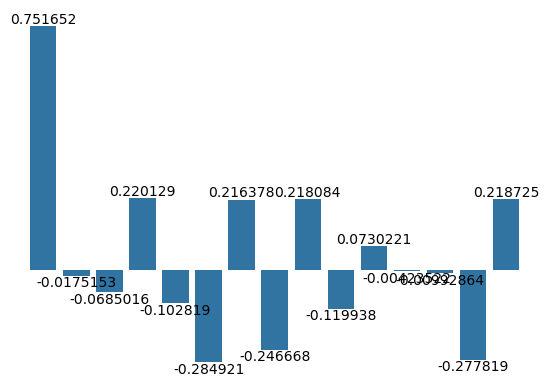

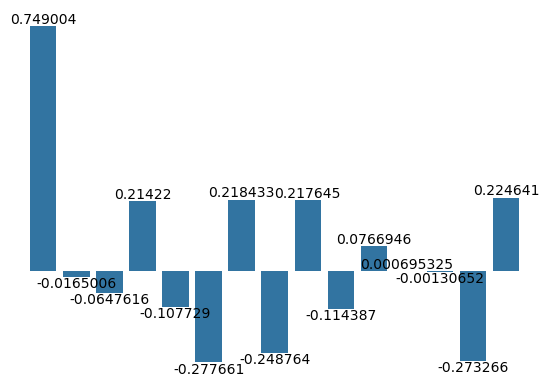

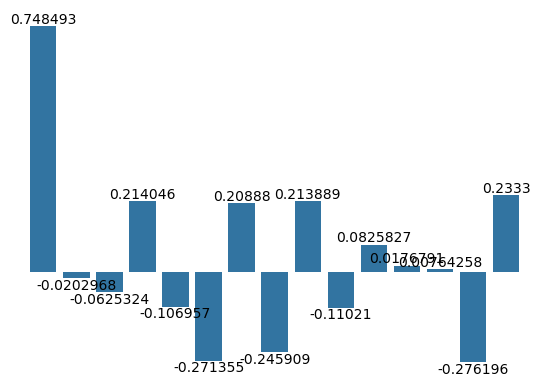

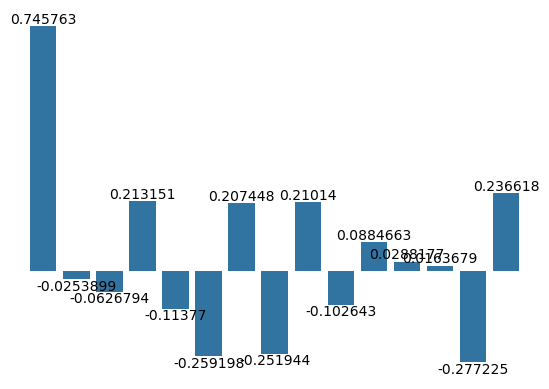

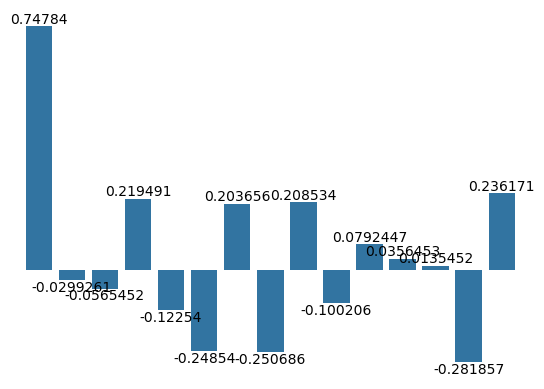

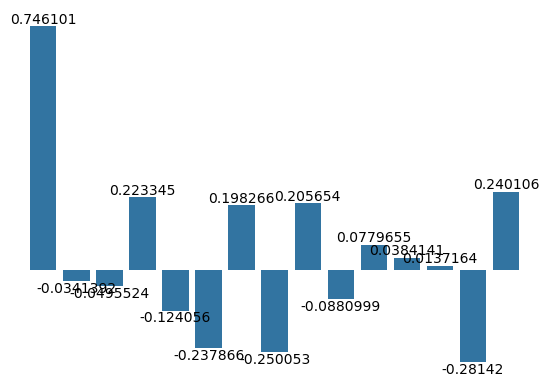

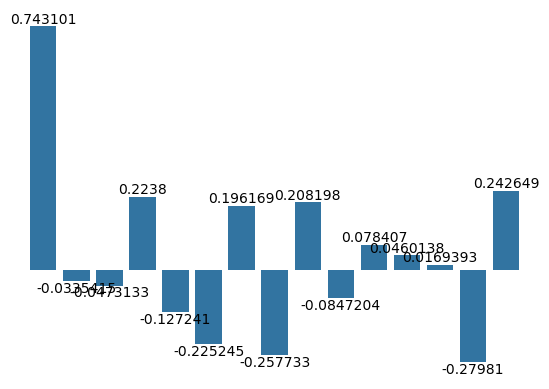

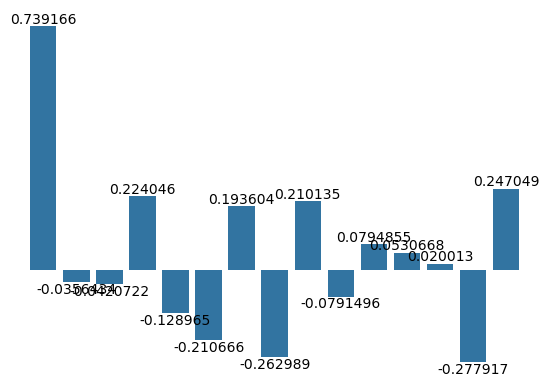

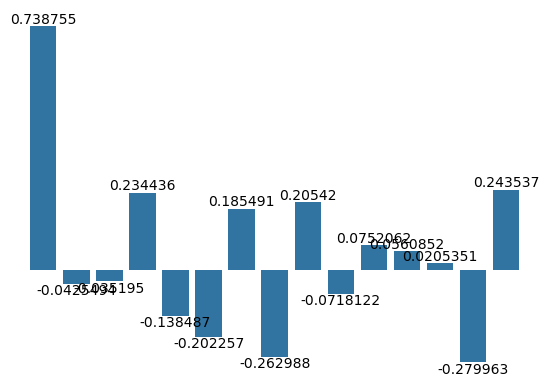

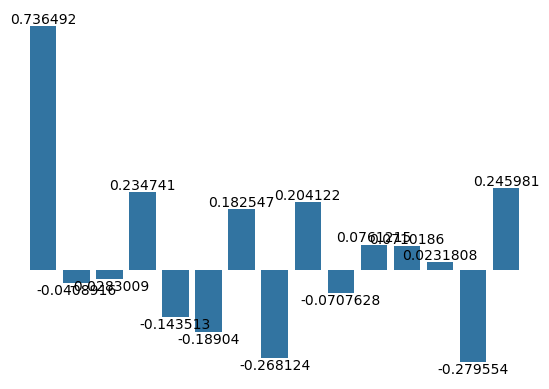

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from DAM import DenseAssociativeMemory

K = 15
N = 30

patterns = np.random.choice([-1,1], size=(K,N))

dam = DenseAssociativeMemory(patterns, n=4, beta=2.0, alpha=0.01)

# pick one pattern and add gaussian noise
target = patterns[0].copy()
noisy = target + 1*np.random.randn(N)
simi_noisy_target = np.dot(noisy, target) / (np.linalg.norm(noisy) * np.linalg.norm(target) + 1e-12)
print(simi_noisy_target)

retrieved, best, energy_trace, similarity_trace = dam.retrieve(noisy, steps=1000)

for i in range(0, 1000, 100):
    ax = sns.barplot(x=np.arange(len(similarity_trace[i])), y=similarity_trace[i])
    ax.bar_label(ax.containers[0])
    plt.axis('off')
    plt.show()

### How similarity with stored patterns evolves with iterations for $\alpha = 0.5$

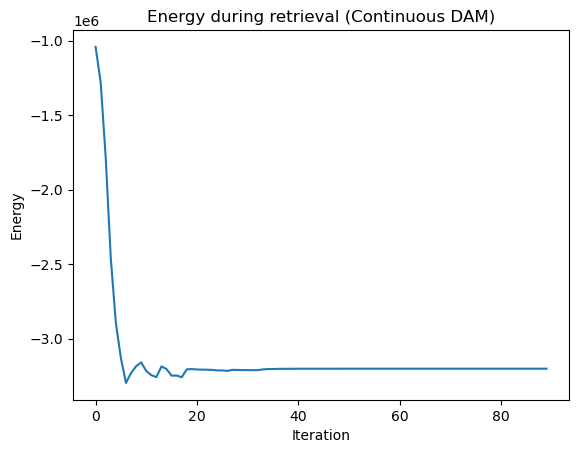

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from DAM import DenseAssociativeMemory

# simple random patterns for testing
K = 15
N = 20
"""
Track changes for different values for the relaxation paramaters

"""
patterns = np.random.choice([-1,1], size=(K,N))

dam = DenseAssociativeMemory(patterns, n=5, beta=2.0, alpha=0.5)

# pick one pattern and add gaussian noise
target = patterns[0].copy()
noisy = target + 0.5*np.random.randn(N)

retrieved, best, energy_trace, similarity_trace = dam.retrieve_differential(noisy, steps=900)

plt.plot(energy_trace)
plt.title("Energy during retrieval (Continuous DAM)")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()



0.6051457908653775
1000


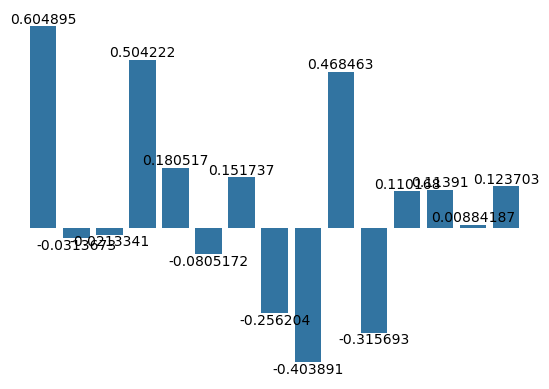

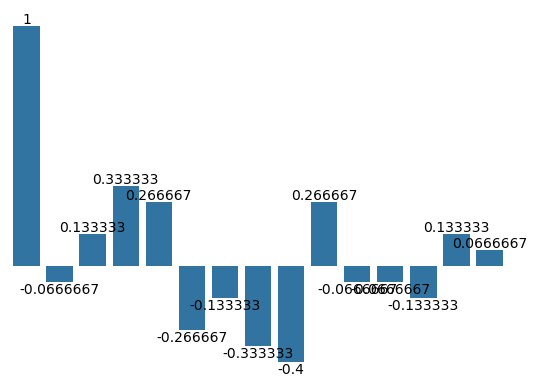

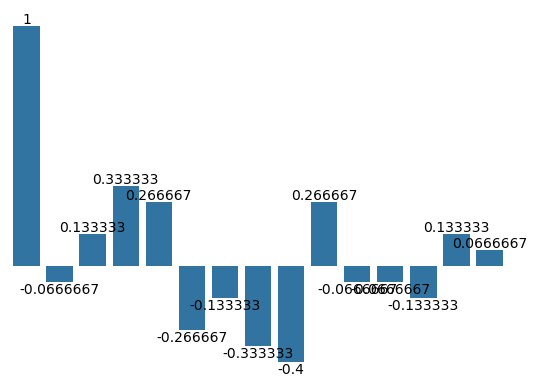

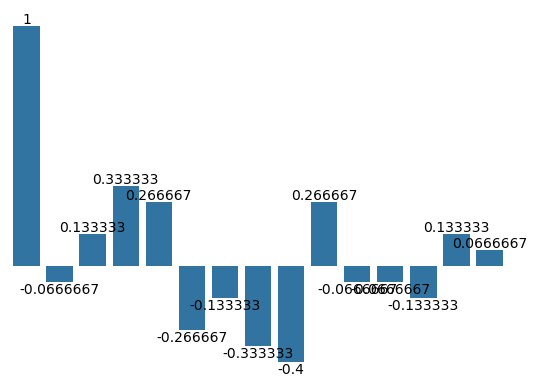

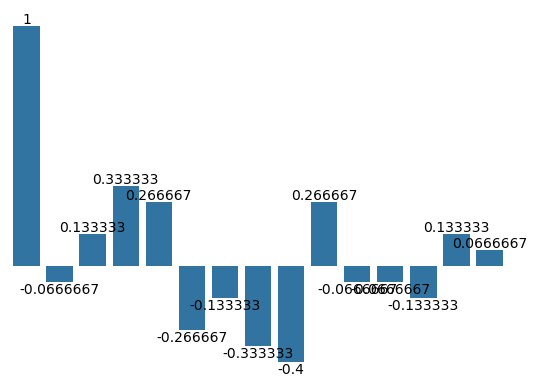

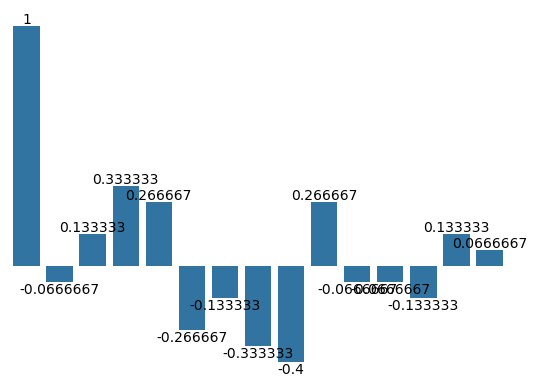

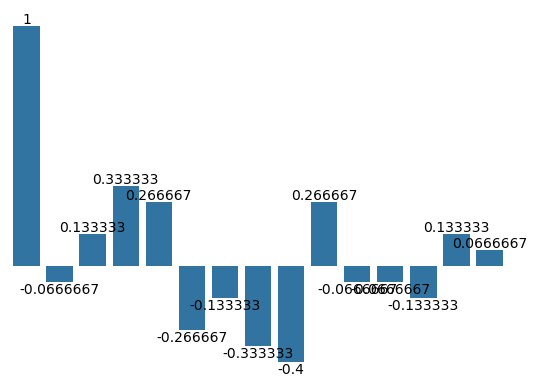

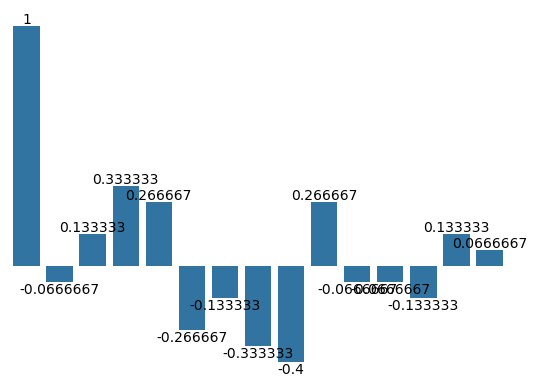

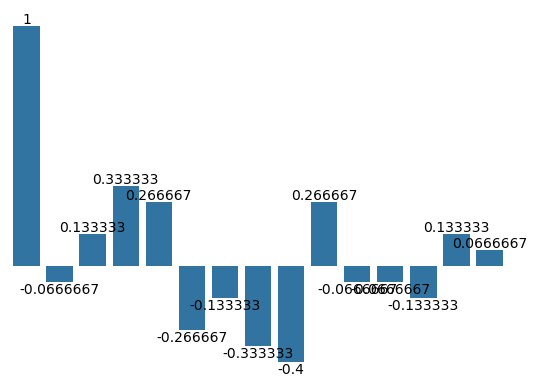

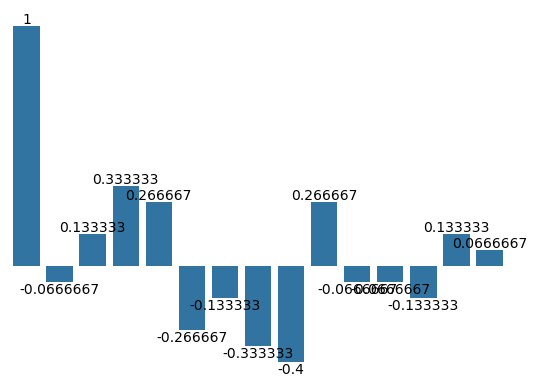

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from DAM import DenseAssociativeMemory

K = 15
N = 30

patterns = np.random.choice([-1,1], size=(K,N))

dam = DenseAssociativeMemory(patterns, n=5, beta=2.0, alpha=0.6)

# pick one pattern and add gaussian noise
target = patterns[0].copy()
noisy = target + 1*np.random.randn(N)
simi_noisy_target = np.dot(noisy, target) / (np.linalg.norm(noisy) * np.linalg.norm(target) + 1e-12)
print(simi_noisy_target)

retrieved, best, energy_trace, similarity_trace = dam.retrieve_differential(noisy, steps=10000)
print(len(similarity_trace))

for i in range(0, len(similarity_trace), 100):
    ax = sns.barplot(x=np.arange(len(similarity_trace[i])), y=similarity_trace[i])
    ax.bar_label(ax.containers[0])
    plt.axis('off')
    plt.show()

## Experiemnts

### The $\beta$ sweep

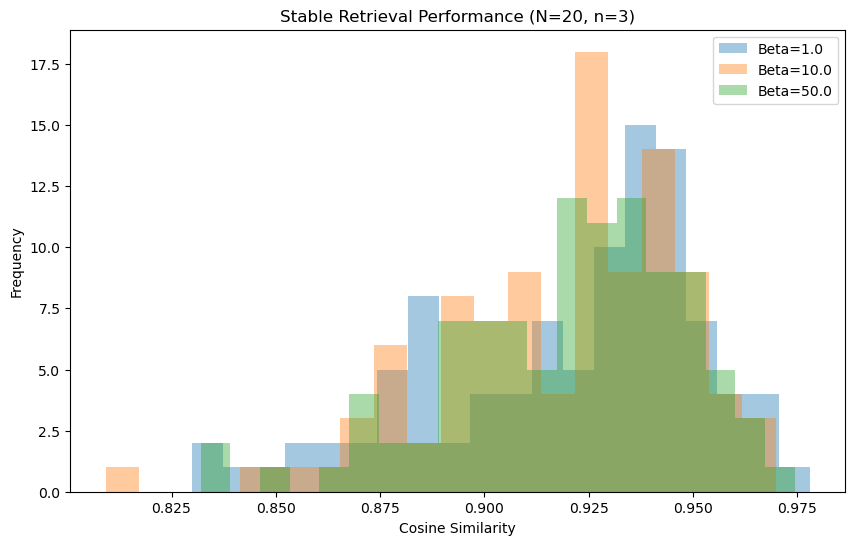

In [62]:
N = 20       # Increased for stability
K = 600        # Higher K, but manageable for n=3
n_power = 3   # Using the Dense property
num_worlds = 5 # Test across 5 different random pattern sets
trials_per_world = 20 

betas = [1.0, 10.0, 50.0]
plt.figure(figsize=(10, 6))

for b in betas:
    all_similarities = []
    for w in range(num_worlds):
        # Fresh patterns for every 'world'
        patterns = np.random.choice([-1.0, 1.0], size=(K, N))
        dam = DenseAssociativeMemory(patterns, n=n_power, beta=b, alpha=0.1)
        
        for _ in range(trials_per_world):
            target = patterns[0]
            noisy = target + 0.5 * np.random.randn(N)
            # Shortened steps since N is larger
            retrieved, _, _, _ = dam.retrieve_differential(noisy, steps=N*2)
            all_similarities.append(cosine(retrieved, target))
    
    plt.hist(all_similarities, bins=20, alpha=0.4, label=f'Beta={b}')

plt.title(f"Stable Retrieval Performance (N={N}, n={n_power})")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

[2, 7, 5, 8, 5, 8, 7, 5, 7, 5, 7, 7, 7, 2, 7, 8, 9, 7, 5, 2, 4, 5, 8, 8, 6, 7, 7, 8, 3, 6, 5, 12, 7, 6, 4, 6, 7, 5, 5, 5, 8, 5, 3, 5, 8, 3, 9, 6, 5, 8]
[10, 9, 9, 9, 5, 6, 9, 5, 10, 7, 12, 11, 8, 13, 9, 9, 9, 3, 6, 6, 5, 10, 8, 11, 10, 12, 8, 10, 8, 4, 11, 11, 12, 10, 9, 7, 9, 8, 10, 11, 10, 9, 13, 10, 8, 7, 9, 7, 5, 9]
[14, 10, 12, 9, 10, 9, 4, 13, 9, 7, 12, 9, 8, 16, 10, 9, 7, 9, 11, 12, 5, 7, 9, 11, 10, 12, 7, 11, 11, 9, 10, 9, 9, 7, 9, 10, 9, 6, 6, 6, 7, 6, 9, 10, 11, 8, 9, 9, 8, 9]
[12, 11, 10, 8, 8, 9, 12, 9, 11, 10, 8, 8, 8, 7, 9, 5, 11, 11, 10, 9, 8, 8, 6, 8, 11, 7, 4, 8, 7, 6, 11, 9, 9, 8, 10, 8, 9, 8, 9, 3, 7, 13, 7, 10, 10, 9, 6, 8, 6, 10]
[8, 9, 12, 8, 7, 5, 10, 10, 11, 14, 7, 8, 8, 13, 12, 6, 10, 11, 10, 10, 12, 8, 10, 8, 5, 5, 8, 11, 7, 11, 9, 8, 7, 8, 7, 8, 4, 13, 10, 15, 11, 8, 8, 12, 11, 10, 7, 6, 5, 5]
[8, 10, 8, 8, 8, 7, 15, 8, 10, 9, 6, 12, 8, 7, 9, 14, 11, 6, 9, 10, 12, 9, 8, 6, 9, 8, 7, 13, 10, 7, 8, 12, 4, 12, 4, 7, 12, 7, 5, 6, 7, 5, 9, 7, 8, 8, 8, 9, 8, 10]
[9,

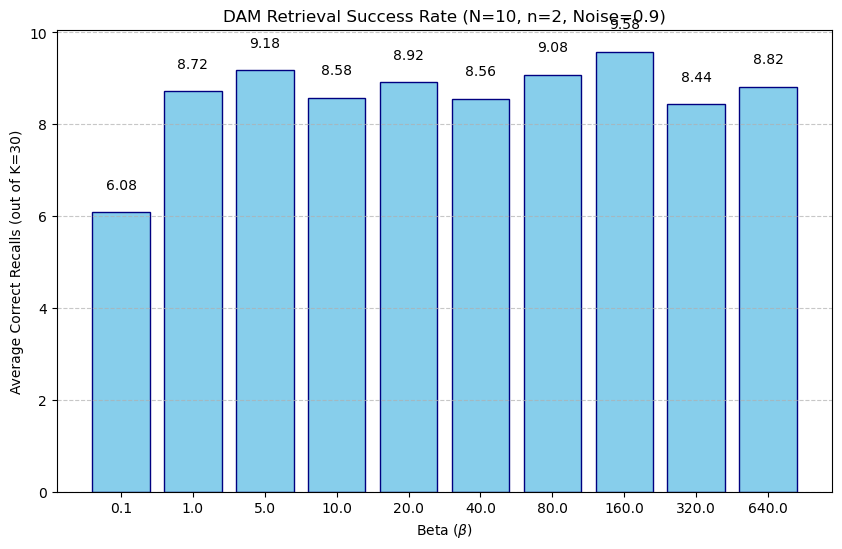

In [85]:
import numpy as np
import matplotlib.pyplot as plt

N = 10
K = 30
n_power = 2        
betas = [0.1, 1.0, 5.0, 10.0, 20.0, 40.0, 80.0, 160.0, 320.0, 640.0]
noise_level = 0.8  
tolerance = 0.90    
num_trials = 50

avg_recalls_per_beta = []

for b in betas:
    trial_counts = []
    for t in range(num_trials):
        patterns = np.random.choice([-1.0, 1.0], size=(K, N))
        
        dam = DenseAssociativeMemory(patterns, n=n_power, beta=b, alpha=0.1)
        
        correct_recalls = 0
        for i in range(K):
            target = patterns[i]
            noisy = target + noise_level * np.random.randn(N)
            
            retrieved, _, _, _ = dam.retrieve_differential(noisy, steps=100)
            
            if cosine(retrieved, target) >= tolerance:
                correct_recalls += 1
        
        trial_counts.append(correct_recalls)
    avg_recalls_per_beta.append(np.mean(trial_counts))

plt.figure(figsize=(10, 6))
bars = plt.bar([str(b) for b in betas], avg_recalls_per_beta, color='skyblue', edgecolor='navy')
plt.xlabel("Beta ($\\beta$)")
plt.ylabel(f"Average Correct Recalls (out of K={K})")
plt.title(f"DAM Retrieval Success Rate (N={N}, n={n_power}, Noise={noise_level})")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()